In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
import torch
torch.manual_seed(0)

# Assignment for COMP 6321 (Winter 2022)

In this assignment, you will familiarize yourself with **recurrent neural networks** (RNNs) (which was the topic of Lecture 5). Specifically, you'll solve four toy tasks of different typology:

1. **Does it contain ones? (2.5 points)** *(L-to-1 problem)*, where an RNN has to encode a binary input sequence and predict (at the end) if the sequence contains at least a "1".

2. **Binary Adder (2.5 points)** *(L-to-L problem)*, where an RNN takes in input two binary numbers and has to return their sum.

3. **Copy Task (2.5 points)** *(seq-to-seq problem)*, where an RNN encodes a binary sequence, and another RNN (decoder) has to replay the original input using the last encoded state only. 

4. **Sinusoid prediction (2.5 points)** *(autoregressive L-to-L problem)*, where we employ an autoregressive RNN to predict the next value that a sinusoid will take.

Moreover, there is the following **optional** exercise:

5. **Language Modeling (5 points)** *(autoregressive L-to-L problem)*, where we employ an autoregressive RNN to predict the next character of a text. We will also use this RNN to generate Shakespeare-like plays. 

In total, **15 points** are up for grab.

We will implement these systems with [PyTorch](https://pytorch.org/tutorials/).

As you might have guessed, we do not really need neural networks to solve the first four tasks above. However, solving these toy tasks will help you to figure out how to deploy machine learning systems that involve RNNs. You can use the same core code on real sequence processing problems (you just have to train the model with more data and enough computing).

- <span style="color:red"><i>Warning 1.</i></span> The assignment must be your personal work. It is not teamwork. You can contact the instructor for clarifications on the questions. Feel free to leave a comment in the Google Colab too.

- <span style="color:red"><i>Warning 2.</i></span> Once you complete the assigment, go to `file`=>`download `and download it as `ipynb` (not as a pdf as done for the labs). You have to submit the assigment to Moodle.

- <span style="color:red"><i>Warning 3.</i></span> For point 5, we suggest to use the GPU made availabl by Colab. To activate it, go to `Runtime` => `Change runtime time `and select `GPU` in hardware accellerator. 

- <span style="color:red"><i>Warning 4.</i></span> Many of the code cells in this notebook re-use the variable names like `X` or `y`, but assign them different data. If you run cells out of order, you may get unexpected results or errors, so be careful when switching between exercises.


Ok, let's start!

**Run the code cell below** to import the needed libraries and to set the PyTorch seed (for replicability).

<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>
<div style="border-bottom: 3px solid black"></div>

## 1. Does it contain ones? (2.5 points)

In this case, we input a sequence of $L$ binary elements (randomly sampled). If there is at least a "1" in that sequence, the output produced by the neural network should be "1". Otherwise, it must be 0. 

For instance:
- If $\mathbf{x}=[0,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0]$, the output should be 1
- If $\mathbf{x}=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]$, the output should be 0
- If $\mathbf{x}=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1]$, the output should be 1

It is possible to solve this problem with an RNN (see Figure below).

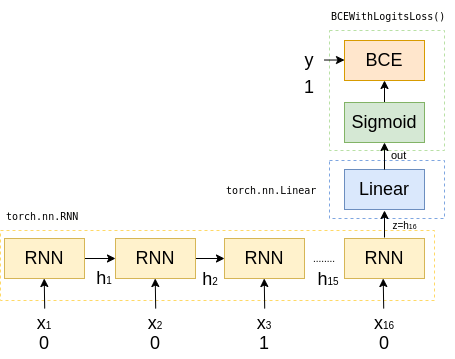

The RNN scans all the elements of the current input sequence $\mathbf{x}=[x_1,x_2,..,x_L]^T$. It outputs a sequence of states $\mathbf{H}$ (one for each time step). For instance, if we use a vanilla RNN:

$\mathbf{h}_t = tanh(\mathbf{W}^{(in)T} \mathbf{x}_t + \mathbf{W}^{(hh)T} \mathbf{h}_{t-1})$

$\mathbf{H}=[\mathbf{h}_1, \mathbf{h}_2, ...,\mathbf{h}_{t-1},\mathbf{h}_t,...,\mathbf{h}_L]^T = \begin{bmatrix}
h_{1,1} & h_{1,2} & ... & h_{1,M}\\
h_{2,1} & h_{2,2} & ... & h_{2,M}\\
... & ... & ... & ...\\
h_{L,1} & h_{L,2} & ... & h_{L,M}\\
\end{bmatrix}$,

where $\mathbf{W}^{(in)}$ and $\mathbf{W}^{(hh)}$ are the learnable parameters. $L$ is the number of elements in the sequence and $M$ is the dimensionality of the hidden state (*hidden_size*).  

Now, we can take the final state $\mathbf{h}_L$ and feed it into a **binary classifier** (based on a linear transformation followed by a sigmoid). The classifier should output something close to zero if the input sequence $\mathbf{x}$ does not contain ones, and something close to one otherwise.  

On top of the classifier, we plug the BCE loss that compares the predictions with the labels (at training time).

We can train this model as already done many times in this course: we have to compute a gradient using the **backpropagation** algorithm and update the parameters with **gradient descent**. Fortunately, we will use PyTorch, which will compute gradients for us using its automatic differentiation engine.

At this level, the problem to solve should be clear enough to you. Let's start by generating some data for training our model:



### Exercise 1.1 &mdash; Create a synthetic dataset (0.5 points)

The Python function below generates $N$ binary sequences of length $L$. The sequences are sampled randomly using the Bernoulli distribution implemented in `torch.bernoulli`. The argument `prob` is the probability to draw a one, which is set to "0.05".  This way, we approximately have 50% of the sequences with ones and 50% that only contain zeros.


**Run the code cell below** to get the data_generation function.

In [ ]:
def data_generation(L, N, D=1, prob=0.05):
  """This function generates random sequences of 0 and 1.
  The label is 1 if there is at least one element of the
  sequence that contains 1.

  Arguments
  ---------
  L : int
    Lenght of the sequences.
  N: int
    Number of examples.
  D: int
    Number of output features.
  prob: float:
    Probability to draw a 1. 
  
  Returns
  ---------
  X: torch.Tensor
    Tensor of dimensionality (L,N,D) containing
    the generated sequences.
  y: torch.Tensor
    Tensor of dimensionality (N,1) containing the labels.
  """
  X = torch.bernoulli(torch.full((N, L, D), prob)).float()
  y = torch.any (X >= 1.0, dim=1).float()
  return X, y

**Write a code** to call the `data_generation` and create the training dataset. Please, store the input sequences into a variable called "X", and the output labels in a variable called $y$.

In [ ]:
L = 16 # sequence length
N = 1000 # number of examples
D = 1 # output features

# Generate data
# Your code here. Aim for 1 line.
X, y = data_generation(L, N)

print(X.shape)
print(y.shape)

torch.Size([1000, 16, 1])
torch.Size([1000, 1])


**Check your answer** by running the code cell below.

In [ ]:
assert isinstance(X, torch.Tensor), "Expected X to be a torch.Tensor"
assert isinstance(y, torch.Tensor), "Expected y to be a torch.Tensor"
assert X.shape == (1000, 16, 1), "X has a wrong shape"
assert y.shape == (1000, 1), "y has a wrong shape"
y_lab = (X.sum(1)>0).float()
assert (y-y_lab).sum()==0, "Labels y not corrected"
print("Correct!")

Correct!


### Exercise 1.2 &mdash; Create the Model (0.75 points)

We are now ready to implement the model described above. When working with a `torch.nn.Module` class (see code below), we normally have to fill two methods: the $\_\_init\_\_$ one (which is called only once when initializing the class) and the $foward$ one that specifies all the computations from the input to the output prediction.

In particular:
- The $\_\_init\_\_$ method has to initialze an RNN with [torch.nn.RNN](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html). Please,  use `batch_first=True`. It also has to initialize a linear transformation with [torch.nn.Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html). The linear transformation has to transform the last hidden state of the RNN into a single scalar (i.e., use `out_features=1`). 

- The $forward$ method has to first feed the inputs into the RNNs. Then, it has to run the linear transformation on top of the last hidden layer. When the model is in the "training" modality (`self.training`), the output before the sigmoid is returned (the reason is that we are going to use the `torch.nn.BCEWithLogitsLoss` as loss, which assumes logits in input). When the model is in eval modality, we have to apply the sigmoid (`torch.sigmoid`) on top of the linear transformation. 


**Complete the code** to implement the desired model:

In [ ]:
class VanillaRNN(torch.nn.Module):
  def __init__(self, input_size=1, hidden_size=1, num_layers=2):
    super(VanillaRNN, self).__init__()
    """The initialization method is used to initialize all the components needed
    to implement our neural model. In this case, we have to initialize a 
    recurrent neural network and a linear transformation."""

    # Initialize the RNN (using torch.nn.RNN). Use batch_first=True as input argument.
    # Your code here. Aim for 1-2 line.
    self.rnn = torch.nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    # Initialize the Linear transformation (using torch.nn.Linear)
    # Your code here. Aim for 1 lines.   
    # hidden_size * sequence_length
    self.linear = torch.nn.Linear(hidden_size*L, 1)

  def forward(self, X):
    """This function processes the input sequence X with an RNN. Then it applies
    a linear transformation on top of the last hidden state. In the eval modality,
    a sigmoid followed by a threshold is applied to output the final prediction.
    
    Arguments
    ---------
    X : torch.Tensor
      Tensor containing the sequences (N, L, 1).
    
    Returns
    ---------
    out: torch.Tensor
      Tensor containing the logits in training modality or the predictions
      in eval modality (N,1). 
    """
    
    # Run the RNN
    # Your code here. Aim for 1 line.
    Z, _ = self.rnn(X)

    # Making the hidden states visible from outside (needed for 1.3)
    self.Z = Z
    
    # Select the last hidden state
    # Your code here. Aim for 1 line.
    z =  Z.reshape(Z.shape[0], -1)

    # Apply linear transformation
    # Your code here. Aim for 1 line.
    out = self.linear(z)

    # Managing eval mode
    if not self.training:
      # Your code here. Aim for 1-2 lines.
      # Remember to apply a threshold on top of the sigmoid to get the prediction.
      out = torch.sigmoid(out)
      out = (out>0.5).float()*1

    return out

**Check your answer** by running the code cell below.

In [ ]:
rnn = VanillaRNN(input_size=1, hidden_size=4, num_layers=2)
rnn.train()
out = rnn(X[0:100,:,:])
assert out.shape==(100,1), "The output of the RNN has an unexpected shape"
rnn.eval()
out = rnn(X[0:100,:,:])
assert out.shape==(100,1), "The output of the RNN has an unexpected shape (in eval mode)"
cnt_0 = torch.count_nonzero(out)
cnt_1 = torch.count_nonzero(1 - out.int())
assert cnt_0 + cnt_1 == 100, "The prediction returned in eval model must be only be 0. \
                              Make sure the threshold is applied"
print("Correct!")

Correct!


### Exercise 1.3 &mdash; Training loop (0.75 points)

Let's now write the training loop. This step is similar to what done in previous labs.

**Complete the code** to implement the training loop:

In [ ]:
# Hyperparameters
lr = 0.01
batch_size = 100
num_epoch = 500
hidden_size = 1
num_layers = 2

# Initialize the Vanilla RNN 
# Your code here. Aim for 1 line
rnn = VanillaRNN(input_size=1, hidden_size=hidden_size, num_layers=num_layers)

# Initialize the Loss. Please, use torch.nn.BCEWithLogitsLoss
# Your code here. Aim for 1 line
loss = torch.nn.BCEWithLogitsLoss()

# Initialize the Optimizer. Please, use torch.optim.Adam (with the lr specified above)
# Your code here. Aim for 1 line
optimizer = torch.optim.Adam(rnn.parameters(), lr=lr)

# Training Loop
for epoch in range(num_epoch):
  for i in range(0, N, batch_size):

    # Read minibatches (for both X and y)
    # Your code here. Aim for 2 lines
    Xi = X[i:i+batch_size]
    yi = y[i:i+batch_size]

    # Run the RNN model
    # Your code here. Aim for 1 line
    logits = rnn(Xi)
    
    # Compute the loss (use l as a variable for the loss)
    # Your code here. Aim for 1 line
    l = loss(logits, yi)

    # Update the parameters (zero_grad, backward, optimization step)
    # Your code here. Aim for 3 lines
    rnn.zero_grad()
    l.backward()
    optimizer.step()

  # Print loss
  if (epoch + 1) % 50 == 0:
      print("Epoch %03d: Train_loss: %.4f " %(epoch+1, l.item()))


Epoch 050: Train_loss: 0.0247 
Epoch 100: Train_loss: 0.0064 
Epoch 150: Train_loss: 0.0029 
Epoch 200: Train_loss: 0.0016 
Epoch 250: Train_loss: 0.0010 
Epoch 300: Train_loss: 0.0007 
Epoch 350: Train_loss: 0.0005 
Epoch 400: Train_loss: 0.0003 
Epoch 450: Train_loss: 0.0003 
Epoch 500: Train_loss: 0.0002 


**Check your answer** by running the code cell below.

In [ ]:
rnn.eval()
X_test = torch.zeros(10,16,1)
assert (rnn(X_test)).sum()==0, "Incorrect prediction. Problems during training?"
assert (rnn(X_test+1)).sum()==10, "Incorrect prediction. Problems during training?"
rnn.train()
print("Correct!")

Correct!


Your output should look like this:

```
Epoch 050: Train_loss: 0.0321 
Epoch 100: Train_loss: 0.0093 
Epoch 150: Train_loss: 0.0045 
Epoch 200: Train_loss: 0.0027 
Epoch 250: Train_loss: 0.0017 
Epoch 300: Train_loss: 0.0012 
Epoch 350: Train_loss: 0.0008 
Epoch 400: Train_loss: 0.0006 
Epoch 450: Train_loss: 0.0004 
Epoch 500: Train_loss: 0.0003 
```

As you can see,  even a tiny neural network like the one used here can easily solve this problem.

Let's now see if it works on some test data as well:

**Complete the code** to implement test the model on the provided inputs:

In [ ]:
# Create Test samples
X_test = torch.zeros(3,16,1)
X_test[0,8,0] = 1
X_test[1,2,0] = 1
X_test[1,12,0] = 1

# Switch model to eval mode
# Your code here. Aim for 1 line
rnn.eval()

# Run prediction
# Your code here. Aim for 1 line
pred = rnn(X_test)

# Print prediction
# Your code here. Aim for 1 line
print(pred)

tensor([[1.],
        [1.],
        [0.]])


**Check your answer** by running the code cell below.

In [ ]:
assert pred[0,0]==True, "Incorrect prediction. Problems during training?"
assert pred[1,0]==True, "Incorrect prediction. Problems during training?"
assert pred[2,0]==False, "Incorrect prediction. Problems during training?"
print("Correct!")

Correct!


### Exercise 1.4 &mdash; Plot activations (0.5 points)

You can now plot the hidden activations over the time axis (we can access them with `rnn.Z`). This can give us some insights into what the network has learned.

**Complete the code** to test the model on the provided inputs:

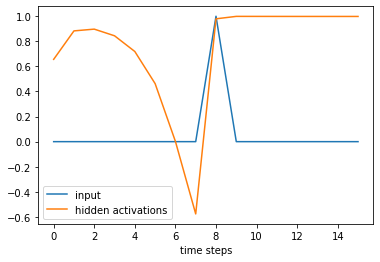

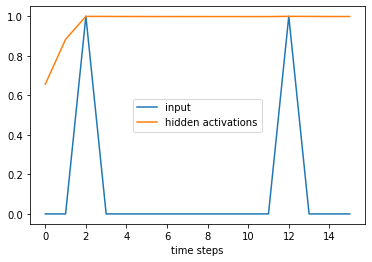

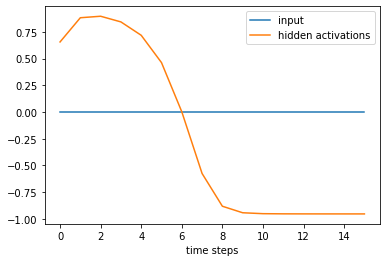

In [ ]:
for i in range(X_test.shape[0]):

  # Your code here. Aim for 5-6 lines. Make sure to detach rnn.Z
  xvals = np.linspace(0, 15, 16)
  x_test = X_test[i, ].T[0,]
  # print(rnn.Z.detach())
  hidden_activation = rnn.Z[i, ].detach().T[0,]
  # print(hidden_activation)
  plt.plot(xvals, x_test, label='input')
  plt.plot(xvals, hidden_activation, label='hidden activations')
  plt.xlabel('time steps')
  plt.legend()
  plt.show()


You should obtain images similar to this ones:

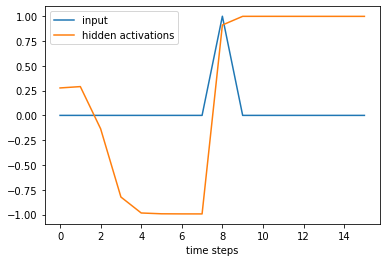

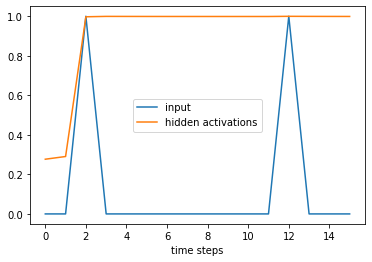

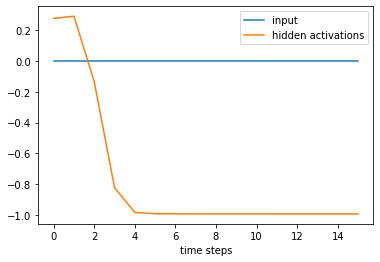

As you can see, the output tends to stay at -1 until a "1" is detected in the sequence. When a 1 is observed, the activation stays at around + 1 until the end. Note that also the opposite behavior might be learned by the network (the following linear transformation can just invert it).



# 2. Binary Adder (2.5 points)

In this case, the RNN takes in input two binary numbers. The output is the sum of the binary inputs (take a look [here](http://web.math.princeton.edu/math_alive/1/Lab1/BinAdd.html), if you do not remember of binary addition works). 

For instance:

with  $\mathbf{X} = \begin{bmatrix}
0 & 1 \\
0 & 1 \\
0 & 0 \\
1 & 1 \\
0 & 1 \\
0 & 0 \\
1 & 1 \\
0 & 0 \\
\end{bmatrix}$, 
the output must be $\mathbf{y} = \begin{bmatrix}
1 \\
1 \\
1 \\
0 \\
1 \\
1 \\
0 \\
0 \\
\end{bmatrix}$. 

By default, the first row represents the most significant bit, while the last one represents the least significant bit (i.e., the summation starts from the last element and goes step by step to the first one).  


It is possible to solve this problem with an RNN (see Figure below).

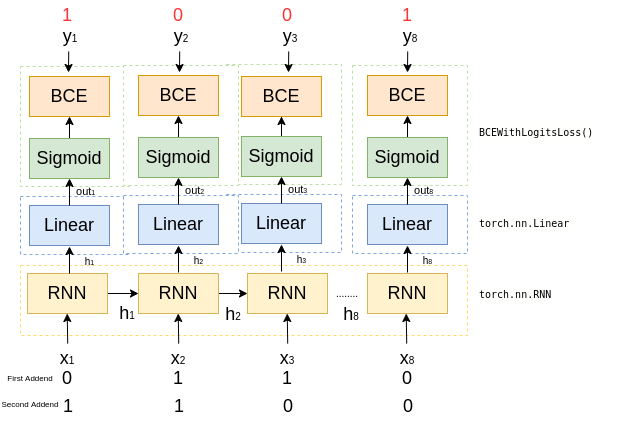

In this case, we need a prediction for each time step.  An RNN scans the inputs from the least important bit to the most important one. We here assume that each binary number is composed of L=8 bits.  The RNN produces a sequence of L hidden states. On top of each hidden state, we apply a binary classifier (linear transformation + sigmoid) that will predict the current output value.

During training, we use the binary cross-entropy loss to compare the predictions with the labels.

First of all, let's create a synthetic dataset for this task.

### Exercise 2.1 &mdash; Create a synthetic dataset (0.5 points)

The following functions will be useful to create a synthetic dataset. The function  `dec2bin` converts the integers contained in the tensor into their corresponding binary values.  The function `bin2dec` performs the opposite conversion.


**Run the code cell below** to get these functions.

In [ ]:
def dec2bin(x, bits):
    """Converts the decimal numbers in the input tensor to binary numbers with the 
    specified number of bits."""
    mask = 2 ** torch.arange(bits - 1, -1, -1).to(x.device, x.dtype)
    return x.unsqueeze(-1).bitwise_and(mask).ne(0).float()

def bin2dec(b, bits):
    """Converts the binary numbers in the input tensor to decimal numbers."""
    mask = 2 ** torch.arange(bits - 1, -1, -1).to(b.device, b.dtype)
    return torch.sum(mask * b, -1)

**Complete the code** to convert the given input tensor into a binary one using `dec2bin`. Use $L=8$ as bit resolution.

In [ ]:
L = 8
x = torch.tensor([[2, 5],[8,18]])

# Your code here. Aim for 1 line
bx = dec2bin(x, L)

print(bx)
print(bx.shape)

tensor([[[0., 0., 0., 0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 0., 1., 0., 1.]],

        [[0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 0., 1., 0., 0., 1., 0.]]])
torch.Size([2, 2, 8])


**Check your answer** by running the code cell below.

In [ ]:
assert (bx[0,0,:]-torch.Tensor([0., 0., 0., 0., 0., 0., 1., 0.])).sum()==0, "Incorrect conversion"
assert (bx[0,1,:]-torch.Tensor([0., 0., 0., 0., 0., 1., 0., 1.])).sum()==0, "Incorrect conversion"
assert (bx[1,0,:]-torch.Tensor([0., 0., 0., 0., 1., 0., 0., 0.])).sum()==0, "Incorrect conversion"
assert (bx[1,1,:]-torch.Tensor([0., 0., 0., 1., 0., 0., 1., 0.])).sum()==0, "Incorrect conversion"
print("Correct!")

Correct!


**Complete the code** to convert the given binary tensor into an integer one using `bin2dec`. Use $L=8$ as bit resolution.

In [ ]:
xb = torch.tensor([[0,0,0,0,0,0,1,0],[0,0,0,0,0,1,1,1], [1,1,1,1,1,1,1,1]])

# Your code here. Aim for 1 line
x_dec = bin2dec(xb, L)

print(x_dec)
print(x_dec.shape)

tensor([  2,   7, 255])
torch.Size([3])


**Check your answer** by running the code cell below.

In [ ]:
assert (x_dec-torch.Tensor([2,7,255])).sum()==0, "Incorrect conversion"
print("Correct!")

Correct!


We can now create a synthetic dataset for training our model.

**Run the code cell below** to get the data generation function.

In [ ]:
def binary_sum_generation(N, bits=8):
  """This function generates data, where each sample is composed of two random 
  binary numbers to add. Each label is a binary number corresponding to the sum 
  of the two inputs.

  Arguments
  ---------
  N: int
    Number of examples.
  bits : int
    The bit resolution of the binary numbers.
 
  
  Returns
  ---------
  X: torch.Tensor
    Tensor of dimensionality (N,bits,2) containing the binary numbers to add.
  y: torch.Tensor
    Tensor of dimensionality (N, bits) containing the labels (i.e, the sum of two binary numbers).
  """

  # Matrix containing integers between 0 and 127 
  X = torch.randint(low=0, high=128, size=(N,2))
  
  # Label (in decimal format)
  y = X.sum(dim=1)

  # Conversion to binary
  Xb =  dec2bin(X,8).transpose(1,2)
  yb = dec2bin(y,8)

  return Xb, yb



**Complete the code** to call the `binary_sum_generation` function and generate the training data.

In [ ]:
# Data generation
N = 1000

# Your code here. Aim for 1 line
X, y = binary_sum_generation(N)

print(X.shape)
print(y.shape)

torch.Size([1000, 8, 2])
torch.Size([1000, 8])


**Check your answer** by running the code cell below.

In [ ]:
a = bin2dec(X[:,:,0],8)
b = bin2dec(X[:,:,1],8)
c = bin2dec(y[:,:],8)
assert ((a + b == c).int().sum()==N), "Wrong Labels"
print("Correct!")

Correct!


### Exercise 2.2 &mdash; Create the Model (1 point)

We are now ready to implement the model described above. 

In particular:
- Similarly to Exercise 1.2, the $\_\_init\_\_$ has to initialize an RNN and a linear transformation. Please use `batch_first=True` for the RNN. 

 
- The $forward$ method has to feed the inputs into the RNN. Then, it has to run the linear transformation on top of each hidden layer (this is the main difference with  Exercise 1.2). When the model is in the "training" modality (`self.training`), the output before the sigmoid is returned (the reason is that we are going to use the `torch.nn.BCEWithLogitsLoss` as loss, which assumes logits in input). When the model is in eval modality, we have to apply the sigmoid (`torch.sigmoid`) on top of the linear transformation. 


Note that the RNN should scan the sequence starting from the least important bit. 
This means that you have to flip the input tensor along the time axis (use `torch.flip`), do the computations, and flip everything again before returning the output. You can do this within the  $forward$ method.


**Complete the code** to implement the desired model:

In [ ]:
class VanillaRNN(torch.nn.Module):
  def __init__(self, input_size=2, hidden_size=16, num_layers=1):
    super(VanillaRNN, self).__init__()
    # Initialize the RNN
    # Your code here. Aim for 1 line
    self.rnn = torch.nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
    
    # Initialize the Linear transformation
    # Your code here. Aim for 1 line
    self.linear = torch.nn.Linear(hidden_size, 1)

  def forward(self, X):
    """This function processes with an RNN the input sequence X from the last 
    element to the first one (X is flipped over the time axis before using the RNN).
    On top of each hidden state, a linear transformation is applied.
    
    Arguments
    ---------
    X : torch.Tensor
      Tensor containing the sequences (N, L, 2).
    
    Returns
    ---------
    out: torch.Tensor
      Tensor (N,L,1) containing the logits at each time step. In eval mode,
      contains the predictions done by the model (N,L). 
    """

    # Flip X (over the time axis)
    # Your code here. Aim for 1 line
    X = torch.flip(X, (0,1))
    
    # Run RNN
    # Your code here. Aim for 1 line
    Z, _ = self.rnn(X)

    # Apply linear transform (on top of each hidden state)
    # Your code here. Aim for 1 line
    out = self.linear(Z)

    # Flip again to retrieve the standard bit order
    # Your code here. Aim for 1 line
    out = torch.flip(out, (0,1))

    # Managing eval mode
    if not self.training:
      # Your code here. Aim for 1 line. Apply a threshold on the top of the sigmoid.
      out = (torch.sigmoid(out)>0.5).float() * 1

    return out

**Check your answer** by running the code cell below.

In [ ]:
rnn = VanillaRNN(input_size=2, hidden_size=4, num_layers=2)
rnn.train()
out = rnn(X[0:100,:,:])
# print(out)
assert out.shape==(100,8,1), "The output of the RNN has an unexpected shape"
rnn.eval()
out = rnn(X[0:100,:,:])
assert out.shape==(100,8,1), "The output of the RNN has an unexpected shape (in eval mode)"
cnt_0 = torch.count_nonzero(out)
cnt_1 = torch.count_nonzero(1 - out.int())
assert cnt_0 + cnt_1 == 100 * 8, "The prediction returned in eval model must be only be 0. \
                              Make sure the threshold is applied"
print("Correct!")

Correct!


### Exercise 2.3 - Training Loop (1 point)
Write the training loop for training this model. The training loop is very similar to that written for Exercise 1.2. 

**Complete the code** to implement the training loop:

In [ ]:
# Hyperparameters
num_epoch = 500
batch_size = 100
lr = 0.002
hidden_size = 8 
num_layers=1

# Initialize the VanillaRNN model
# Your code here. Aim for 1 line.
rnn = VanillaRNN(input_size=2, hidden_size=hidden_size, num_layers=num_layers)

# Initialize the optimizer. Use  torch.optim.Adam with the specified lr.
# Your code here. Aim for 1 line.
optimizer = torch.optim.Adam(rnn.parameters(), lr=lr)

# Initialize the loss. Use  torch.nn.BCEWithLogitsLoss.
# Your code here. Aim for 1 line.
loss = torch.nn.BCEWithLogitsLoss()

# Training Loop
for epoch in range(num_epoch):
  for i in range(0, N, batch_size):

    # Minibatch selection (for X and Y)
    # Your code here. Aim for 2 lines.
    Xi = X[i:i+batch_size]
    yi = y[i:i+batch_size]

    # Running the RNN
    # Your code here. Aim for 1-2 lines.
    logits = rnn(Xi)

    # Apply the loss
    # Your code here. Aim for 1 line.
    l = loss(logits[:,:,0], yi)

    
    # Update parameters
    # Your code here. Aim for 3 lines.
    rnn.zero_grad()
    l.backward()
    optimizer.step()

  # Print loss
  if (epoch + 1) % 50 == 0:
      print("Epoch %03d: Train_loss: %.4f " %(epoch+1, l.item()))

Epoch 050: Train_loss: 0.3946 
Epoch 100: Train_loss: 0.0432 
Epoch 150: Train_loss: 0.0153 
Epoch 200: Train_loss: 0.0076 
Epoch 250: Train_loss: 0.0045 
Epoch 300: Train_loss: 0.0028 
Epoch 350: Train_loss: 0.0019 
Epoch 400: Train_loss: 0.0013 
Epoch 450: Train_loss: 0.0009 
Epoch 500: Train_loss: 0.0007 


You should see something like this in output:


```
Epoch 050: Train_loss: 0.5975 
Epoch 100: Train_loss: 0.0517 
Epoch 150: Train_loss: 0.0155 
Epoch 200: Train_loss: 0.0077 
Epoch 250: Train_loss: 0.0046 
Epoch 300: Train_loss: 0.0030 
Epoch 350: Train_loss: 0.0020 
Epoch 400: Train_loss: 0.0014 
Epoch 450: Train_loss: 0.0010 
Epoch 500: Train_loss: 0.0008 
```



As you can see, the model converges fast also in this case.
We can feed some test data to double-check that everything is fine.

**Complete the code** to implement to evaluate the model on the provided inputs.


In [ ]:
# Decimal numbers
a = torch.tensor([101, 3, 23])
b = torch.tensor([67, 91, 12])
c = a + b

# Conversion to binary numbers
a = dec2bin(a, 8)
b = dec2bin(b, 8)

# print(a.shape)
print(a)
# print(b.shape)
print(b)
# Concatenate a and b in a single tensor
# Your code here. Aim for 1 lines.
# Make sure that the resulting tensor has shape (3, 8, 2)
a = a.unsqueeze(dim=2)
b = b.unsqueeze(dim=2)
X_test = torch.cat([a,b], dim=2)
print(X_test)
print(X_test.shape)

# Put the model in eval mode
# Your code here. Aim for 1 line.
rnn.eval()

# Run the model
# Your code here. Aim for 1 line.
out = rnn(X_test)
print(out)
# Convert the output to decimal format
out_decimal = bin2dec(out[:,:,0], 8)

print(out_decimal)

tensor([[0., 1., 1., 0., 0., 1., 0., 1.],
        [0., 0., 0., 0., 0., 0., 1., 1.],
        [0., 0., 0., 1., 0., 1., 1., 1.]])
tensor([[0., 1., 0., 0., 0., 0., 1., 1.],
        [0., 1., 0., 1., 1., 0., 1., 1.],
        [0., 0., 0., 0., 1., 1., 0., 0.]])
tensor([[[0., 0.],
         [1., 1.],
         [1., 0.],
         [0., 0.],
         [0., 0.],
         [1., 0.],
         [0., 1.],
         [1., 1.]],

        [[0., 0.],
         [0., 1.],
         [0., 0.],
         [0., 1.],
         [0., 1.],
         [0., 0.],
         [1., 1.],
         [1., 1.]],

        [[0., 0.],
         [0., 0.],
         [0., 0.],
         [1., 0.],
         [0., 1.],
         [1., 1.],
         [1., 0.],
         [1., 0.]]])
torch.Size([3, 8, 2])
tensor([[[1.],
         [0.],
         [1.],
         [0.],
         [1.],
         [0.],
         [0.],
         [0.]],

        [[0.],
         [1.],
         [0.],
         [1.],
         [1.],
         [1.],
         [1.],
         [0.]],

        [[0.],
   

**Check your answer** by running the code cell below.

In [ ]:
assert  sum(out_decimal - torch.tensor([168,  94,  35]))==0, "Wrong prediction"
print('correct')

correct


# 3. Copy Task (2.5 points)
We now try to solve another toy task. This time, we want to use RNNs to solve a variant of the famous copy-task. Basically, we read the inputs with an RNN (called encoder). We then ask another RNN (called decoder) to replay the original inputs (in the same order) given the last encoded state only. 

The figure below shows how we can use RNNs to approach this problem.


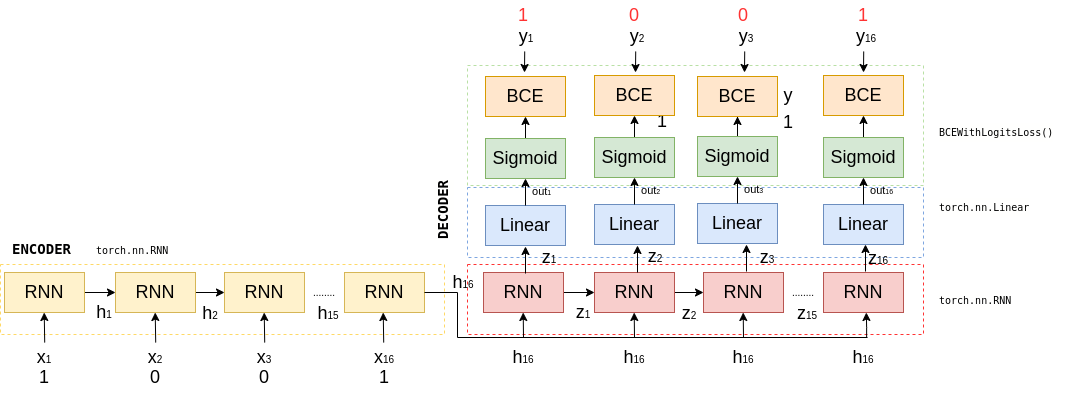

This time the problem can be framed as a **sequence-to-sequence** problem.

The encoder receives in input a sequence of L elements (for instance, $\mathbf{x} = [0,0,1,1,0,0,0,1,1,1]$). The encoder processes this sequences and outputs the hidden states $\mathbf{H}=[\mathbf{h}_1, \mathbf{h}_2, ..., \mathbf{h}_L]^T$. 

The decoder takes in input $\mathbf{h}_L$ and has to regenerate $\mathbf{x} = [0,0,1,1,0,0,0,1,1,1]$ in output. We can feed $\mathbf{h}_L$ into all the inputs of the decoder. On top of each decoded hidden state, we can apply a binary classifier as done in Exercise 2.

Note that this task requires learning long-term dependences because the input to replay is "far away" from the place where it is reconstructed. 

Let's first create a dataset for this problem.

### Exercise 3.1 &mdash; Dataset Creation 
We can create the dataset using the `data_generation` function implemented for Exercise 1. We have to set `prob=0.5` to approximatively have the same number of zeros and ones in the sequence.


**Run the following code** to generate the training dataset:

In [ ]:
L = 16 # sequence length
N = 2000 # number of examples
D = 1 # output features

X, _ = data_generation(L, N, D=1, prob=0.5)

print(X.shape)

torch.Size([2000, 16, 1])


### Exercise 3.2 &mdash; Create the Model (1.5 point)

We are now ready to implement the model described above. 

In particular:
- The $\_\_init\_\_$ has to initialize two RNNs (one for the encoder and one for the decoder). Please use `batch_first=True` for both. We also have to initialize the linear transformation applied on top of all the decoded steps.

 
- The $forward$ method has to first feed the inputs into the RNN encoder. Then, we select the last hidden state and feed it into the RNN decoder (to all its inputs). On top of each hidden state of the decoder, we apply a linear transformation. When the model is in train modality (`self.training`), the output before the sigmoid is returned. When the model is in eval modality, we have to apply the sigmoid (`torch.sigmoid`) on top of the linear transformation. 


**Complete the code** to implement the desired model:

In [ ]:
class EncoderDecoderRNN(torch.nn.Module):
  def __init__(self, rnn_type=torch.nn.RNN, input_size=1, hidden_size=8, num_layers=1):
    super(EncoderDecoderRNN, self).__init__()
    # We here use rnn_type becuase we will also try an LSTM model.
    
    # Encoder initialization
    # Your code here. Aim for 1 line. Use batch_first=True
    self.encoder = torch.nn.RNN(input_size, hidden_size, num_layers, batch_first=True)

    # Decoder initialization
    # Your code here. Aim for 1 line. Use batch_first=True
    self.decoder = torch.nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
    
    # Linear initialization
    # Your code here. Aim for 1 line
    self.linear = torch.nn.Linear(hidden_size, input_size)

  def forward(self, X):
    """This function encodes the input sequences with an RNN. A decoder is fed with
    the last encoded state and generates an output sequence with the same length
    of the input one.
    
    Arguments
    ---------
    X : torch.Tensor
      Tensor containing the sequences (N, L, 1).
    
    Returns
    ---------
    out: torch.Tensor
      Tensor (N,L,1) containing the logits for each decoded output. 
    """
    # Run the RNN encoder
    # Your code here. Aim for 1 line
    # print(X.size())
    H, _ = self.encoder(X)
    # print(H.size())
    
    # Select the last hidden state
    # Your code here. Aim for 1 line
    # Hint: the selected state must have dimensionality (batch, 1, features)
    h = H[-1:, -1:, :]
    # print(h.size())
    # print(h)

    # Feed all the decoding steps with the last hidden state.
    # This requires to concatenate h, N times over the time axis (dim=1)
    # Your code here. Aim for 1 line
    h_conc = torch.cat([h for i in range(X.size(dim=0))], dim=1)
    # print(h_conc.size())

    # Run the decoder (with the last state in inputs to all steps)
    # Your code here. Aim for 1 line
    Z, _ = self.decoder(X, h_conc)
    
    # Run the linear transformation
    # Your code here. Aim for 1 line
    out = self.linear(Z)

    if not(self.training):
      # Your code here. Aim for 1 line. Apply the sigmoid and a threshold on it.
      out = (torch.sigmoid(out)>0.5).float() * 1

    return out

### Exercise 3.3 &mdash; Training Loop (1 point)
Now, we can train the model. This time, we implement the training loop in a function called `training_loop`. This way,  we can easily reuse it in the following:


**Complete the code** to implement the training loop:

In [ ]:
# Hyperparameters
num_epoch = 1000
batch_size = 100
lr = 0.004
hidden_size = 16
num_layers= 1

# Initialization
# Your code here
rnn = EncoderDecoderRNN(hidden_size=hidden_size, num_layers=num_layers)
loss = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=lr)

def training_loop(X, y, model, loss, optimizer, num_epoch=500, batch_size=100):

  # Getting number of input samples
  N = X.shape[0]

  # Training Loop
  for epoch in range(num_epoch):
    for i in range(0, N, batch_size):

      # Minibatch selection (on X and y)
      # Your code here. Aim for 2 lines
      Xi = X[i:i+batch_size]
      yi = y[i:i+batch_size]
      
      # Run the RNN encoder/decoder
      # Your code here. Aim for 1 line
      logits = rnn(Xi)

      # Compute the loss
      # Your code here. Aim for 1 line
      # print(yi.size())
      l = loss(logits, yi)

      # Update the parameters
      # Your code here. Aim for 3 line
      rnn.zero_grad()
      l.backward()
      optimizer.step()

    # Print loss
    if (epoch + 1) % 50 == 0:
        print("Epoch %03d: Train_loss: %.4f " %(epoch+1, l.item()))

# Run the training loop
training_loop(X, X, rnn, loss, optimizer, num_epoch, batch_size)

Epoch 050: Train_loss: 0.0029 
Epoch 100: Train_loss: 0.0007 
Epoch 150: Train_loss: 0.0003 
Epoch 200: Train_loss: 0.0002 
Epoch 250: Train_loss: 0.0001 
Epoch 300: Train_loss: 0.0001 
Epoch 350: Train_loss: 0.0000 
Epoch 400: Train_loss: 0.0000 
Epoch 450: Train_loss: 0.0000 
Epoch 500: Train_loss: 0.0000 
Epoch 550: Train_loss: 0.0000 
Epoch 600: Train_loss: 0.0000 
Epoch 650: Train_loss: 0.0000 
Epoch 700: Train_loss: 0.0000 
Epoch 750: Train_loss: 0.0000 
Epoch 800: Train_loss: 0.0000 
Epoch 850: Train_loss: 0.0000 
Epoch 900: Train_loss: 0.0000 
Epoch 950: Train_loss: 0.0000 
Epoch 1000: Train_loss: 0.0000 


You should see an output simlar to this one:


```
Epoch 050: Train_loss: 0.4735 
Epoch 100: Train_loss: 0.3462 
Epoch 150: Train_loss: 0.1394 
Epoch 200: Train_loss: 0.0084 
Epoch 250: Train_loss: 0.0004 
Epoch 300: Train_loss: 0.0002 
Epoch 350: Train_loss: 0.0001 
Epoch 400: Train_loss: 0.0416 
Epoch 450: Train_loss: 0.0003 
Epoch 500: Train_loss: 0.0002 
Epoch 550: Train_loss: 0.0001 
Epoch 600: Train_loss: 0.0882 
Epoch 650: Train_loss: 0.0003 
Epoch 700: Train_loss: 0.0001 
Epoch 750: Train_loss: 0.0003 
Epoch 800: Train_loss: 0.0001 
Epoch 850: Train_loss: 0.0001 
Epoch 900: Train_loss: 0.0000 
Epoch 950: Train_loss: 0.0000 
Epoch 1000: Train_loss: 0.0000 
```
The network converges well (despite some "turbolence" that might happen likely caused by large gradients). We can now try some test inputs.

**Complete the code** to implement the test the model with the provided inputs:

In [ ]:
# Test tensor
X_test = torch.Tensor([0,1,0,0,1,1,0,0,0,1,1,1, 0,0,0,0])
X_test = X_test.unsqueeze(0).unsqueeze(2) # Thi makes sure the dimension is the one expected by the RNN (1,16,1)

# Put the model in eval mode
# Your code here. Aim for 2 lines
rnn.eval()

# Run the model
# Your code here. Aim for 2 lines
out = rnn(X_test)
print(out[0,:,0])

tensor([0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0.])


In [ ]:
assert (X_test - out[0,:,0]).sum()==0, "Wrong prediction"
print('correct')

correct


As an optional exercise, try to see what happens when increasing the sequence length $L$. You will see that a Vanilla RNN is going to struggle to remember long sequences of elements. Fortunately, there are recurrent neural networks such as the Long short-term memory (LSTM) that are more suitable for memorizing long-term dependencies (feel free to replace the vanilla RNN with an LSTM or a GRU). 

# 4. Sinusoid Prediction (2.5 points)

In this exercise, we will familiarize ourselves with autoregressive RNNs. We will use them to predict the next value in a time series. The architecture that we are going to implement is illustrated in the figure below:

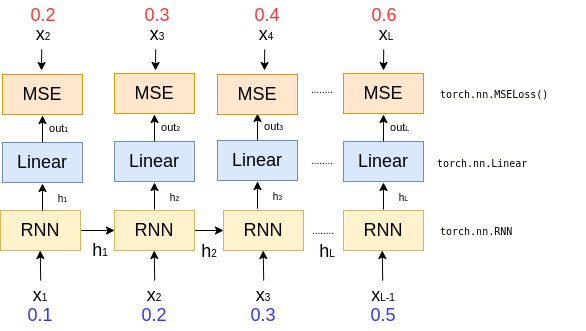

As you can see, the RNN scans all the time steps of the input sequence. At each step, the network predicts the next value. At time step $t$, the RNN is fed by the previous hidden state $h_{t-1}$ and by the previously predicted output ($out_t$). Actually, during training is it possible to feed the network with the previous actual value (label) rather than using the predicted one. This operation is called **teacher forcing**. 

The term *autoregressive* derives from the previous output that is fed back into the system. The labels are simply derived from shifting the input sequence to the left.

You can use an autoregressive RNN for many applications (e.g., stock prediction). Here, for simplicity, we predict the next value of a sinusoidal signal. The sinusoids will have different frequencies and phases. 

First of all, let's create a dataset for this problem.


### Exercise 4.1 &mdash; Dataset Creation (0.5 points)
A sinusoid in the time domain can be written as:

$y(t) = A sin(2\pi ft + \phi)$, where:

- $A$ is the amplitude of the sinusoid.
- $f$ is the frequency of the sinusoid (in Hz).
- $t$ is the time expressed (in seconds).
- $\phi$ is the phase (shift) of the sinusoid (in radiants).

As shown in the figure below, we work with discrete sinusoids. We thus have to discretize the time axis by taking the value of the sinusoid at every $T_s$ second (sampling period).

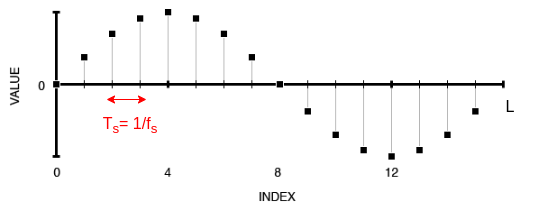

A discrete sinusoid can be written as:

$y[n] = A sin(2\pi f \frac{n}{f_s} + \phi)$, where:
*   $n$ is the index of the sequence element (e.g., $n=0$, $n=1$, $n=2$,.., $n=L-1$).
*   $f_s = \frac{1}{T_c}$ is the sampling rate (also called sampling frequency) expressed in Hz. In this exercise, we will use a fixed sample rate of 8000 Hz.

**Complete the code** to compute a sinusoid of length $L$ samples with a given $A$, $f$, $f_s$, and $\phi$:


In [ ]:
print(torch.linspace(0, 10, steps=10))

tensor([ 0.0000,  1.1111,  2.2222,  3.3333,  4.4444,  5.5556,  6.6667,  7.7778,
         8.8889, 10.0000])


In [ ]:
import math

def sinusoid(A=1.0, f=500, phi=0, sample_rate=8000,L=100):
  """Computes a sinusoid of length L samples given:
    - A (amplitude)
    - f (frequency in Hz)
    - phi (the phase shift in radiants)
    - sample rate (sampling frequency in Hz)
  """ 
  # Your code here. Aim for 2-3 lines
  # Use torch.linspace to define a grid of L points ranging from 0 to L-1.
  # Use torch.sin for the sinusoid.
  n = torch.linspace(0, L, steps=L)
  n = 2*math.pi*f*n/sample_rate + phi
  return A*torch.sin(n)

# print(sinusoid().size())

Now, you can plot some sinusoids generated with the code above.

**Write the code** to plot the sinusoid in the following three cases:
1. Plot the sinusoid with the default parameters.
2. Plot a sinusoid with frequency $f=100$ Hz.
3. Plot a sinusoid with frequency $f=1000$ Hz and $\phi=\pi/2$.


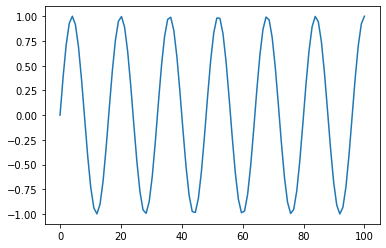

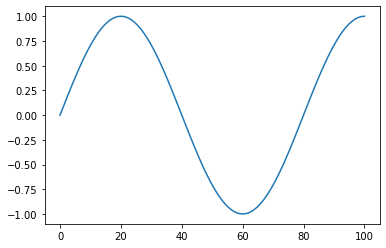

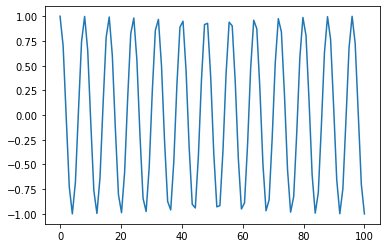

In [ ]:
# Your code here. Aim for 3 lines for each plot
L = 100
x = torch.linspace(0, L)
plt.plot(x, sinusoid()) 
plt.show()

plt.plot(x, sinusoid(f=100)) 
plt.show()

plt.plot(x, sinusoid(f=1000, phi=math.pi/2)) 
plt.show()

You should see the following plots:

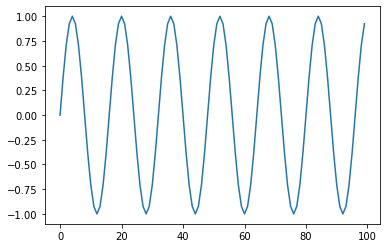


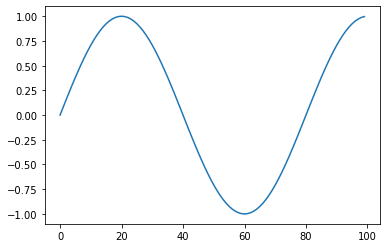


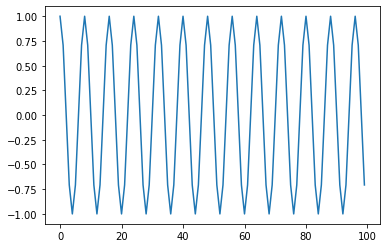

**Check your answer** by running the code cell below.

In [ ]:
out = sinusoid()
assert out.dtype==torch.float32, "Expected out to be float 32"
assert out.shape[0]==100, "Unexpected shape"
assert out[0]==0.0, "t[0] must be zero (when phi is 0)"
out_90 = sinusoid(phi=0.5*math.pi)
assert torch.allclose((out**2 + out_90**2),torch.ones(100)), "Unexpected result when phi =pi/2"
out_180 = sinusoid(phi=math.pi)
assert (out_180+out).sum() < 1e-05, "Unexpected result when phi =pi/2"
out = sinusoid(A=0)
assert out.sum()==0, "Something wrong with the amplitude A"
print("Correct!")

Correct!


Let's now create a dataset by drawing sinusoids with random frequency and phase. In particular, we would like to sample these two variables in the following way:

*  $f$ is sampled from a uniform distribution ranging from 100 ($fmin$) to 1000 Hz ($fmax$).
*  $\phi$ is sampled from a uniform distribution rangign from 0 ($phi\_min$) to $\pi$ ($phi\_max$).

For simplicity, we assume that the amplitude $A$ is one for the sinusoids.


**Complete the code** to draw N sinusoids of length L=100:


In [ ]:
def data_generation(N, L=100, A=1.0, fmin=100, fmax=1000, phi_min=0, phi_max=math.pi):
  """Generates a dataset of sinusoids with different frequencies and phases. 
    
    Arguments
    ---------
    N: int
      Number of sinusoids to draw.
    L : int
      Lenght of the sinusoids.
    A: float
      Amplitide of the sinusoids.
    fmin: float
      Lower value of the frequency.
    fmax: float
      Upper value of the frequency.
    phi_min: float
      Lower value of the phase.
    phi_max: float
      Upper value of the phase.

    Returns
    ---------
    X: torch.Tensor
      Tensor of dimensionality (N,L,1) containing
      the generated sequences.
  """
  # Your code here. Aim for 9-10 lines.
  # Hints:
  # - You can use a for loop that generates all the sequences one by one.
  # - Use the method .uniform_ to draw samples from the uniform distribution.
  # - Use the sinusoid function defined above.
  # - Make sure that the output will have dimensionality (N, L, 1). Remember that
  #   RNNs need in input 3-dimensional tensors.
  f = torch.FloatTensor(N).uniform_(fmin, fmax)
  phi = torch.FloatTensor(N).uniform_(phi_min, phi_max)
  # print(f)
  # print(phi)
  X = torch.empty(size=(N, L, 1))
  for i in range(N):
    s = sinusoid(A=A, f=f[i], phi=phi[i], L=L)
    X[i] = torch.unsqueeze(s, dim=-1)
  return X

print(data_generation(10).size())

torch.Size([10, 100, 1])


**Check your answer** by running the code cell below.

In [ ]:
out = data_generation(15)
assert out.dtype==torch.float32, "Expected out to be float32"
assert out.shape==(15,100,1), "Unexpected shape"
out = data_generation(15, L=10)
assert out.shape==(15,10,1), "Unexpected shape"
out = data_generation(15, A=0)
assert out.sum()==0, "Unexpected  output with A=0"
out = data_generation(15, A=1, L=100, fmin=1000, fmax=1000, phi_min=0, phi_max=0)
# print(out.min())
# print(torch.Tensor([-1]))
assert torch.allclose(out.min(),torch.Tensor([-1]),rtol=0.01), "Unexpected  output with A=1"
assert torch.allclose(out.max(),torch.Tensor([1]), rtol=0.01), "Unexpected  output with A=1"
out = data_generation(15, A=1, fmin=0, fmax=0, phi_min=0, phi_max=0)
assert torch.allclose(out,torch.Tensor([0])), "Unexpected  output with f=0 and phi=0"
out = data_generation(15, A=1, fmin=0, fmax=0, phi_min=math.pi/2, phi_max=math.pi/2)
assert torch.allclose(out,torch.Tensor([1])), "Unexpected  output with f=0 and phi=pi/2"
print("Correct!")

Correct!


Let's now generate the training and test data. We generate 2000 sequences for training and 200 for test.


**Complete the code** to generate the training and test datasets. Also, plot one sinusoid from the training set and one from the test set.

torch.Size([2000, 100, 1])
torch.Size([200, 100, 1])


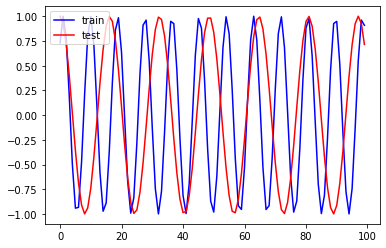

In [ ]:
N_train = 2000
N_test = 200

# Data generation
tr_data = data_generation(N_train)
te_data = data_generation(N_test)

print(tr_data.size())
print(te_data.size())

# Plot (in the same figure) one sinusoid from training (tr_data[0]) 
# and one from test (te_data[0])
plt.plot(tr_data[0],color='b', label='train')
# plt.plot(tr_data[1],color='b', label='train')
# plt.plot(tr_data[2],color='b', label='train')
plt.plot(te_data[0],color='r', label='test')
plt.legend(loc="upper left")
plt.show()

You should plot something like this:

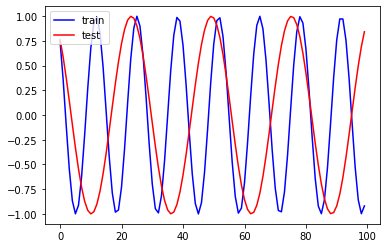

### Exercise 4.2 — Create the Model (1 point)
We are now ready to implement the model described above.

In particular:

- The ` __init__`  has to initialize the RNN layer and the linear one with the expected dimensionalities. This time we employ a GRU (`torch.nn.GRU`) as an RNN. Use `batch_first=True` as done in previous exercises.

- The  forward  method has to first feed the inputs into the RNN. Then, a linear transformation is employed to convert each hidden state into a single real number. 


**Complete the code** to implement the RNN:

In [ ]:
class RNN(torch.nn.Module):
  def __init__(self, input_size=1, hidden_size=8, num_layers=1):
    super(RNN, self).__init__()
    # Your code here
    self.rnn = torch.nn.GRU(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
    self.linear = torch.nn.Linear(hidden_size, 1)

  def forward(self, X):
    """This function processes with an RNN the input sequence X from the last 
    element to the first one. On top of each hidden state, a linear transformation
    that returns a scalar prediction for each time step is applied.
    
    Arguments
    ---------
    X : torch.Tensor
      Tensor containing the sequences (N, L, 1).
    
    Returns
    ---------
    out: torch.Tensor
      Tensor (N,L,1) containing the output prediction at each time step.    
    """
    # Run the RNN + linear transformation
    # Your code here. Aim for 2 lines
    H, h_n = self.rnn(X)
    out = self.linear(H)
    return out

### Exercise 4.3 &mdash; Training Loop (1 point)
Now, we can train the model. This is very similar to what was done in the previous exercises. The main differences are:
- this time we have to use the Mean Squared Error (MSE) as an objective (`torch.nn.MSELoss()`).
- you can derive the labels by shifting the input X to the left (one way is to use `torch.roll`). Note also that you have to remove the last time step to both
inputs and labels (due to the aforementioned shift).

**Complete the code** to implement the training loop:

In [ ]:
# Hyperparameters
num_epoch = 100
batch_size = 128
lr = 0.01
hidden_size = 32
num_layers= 1

# Initialization
# Your code here
rnn = RNN(hidden_size=hidden_size, num_layers=num_layers)
loss = torch.nn.MSELoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=lr)

def training_loop(X, model, loss, optimizer, num_epoch=500, batch_size=100):
  # Derive labels by shifting X
  Y = torch.roll(X, -1, 1)
  # print(X)
  # print(Y)
  # print(Y.size())  
  # Remove the last time steps from X and Y
  X = X[:, :-1, :]
  Y = Y[:, :-1, :]
  # print(X.size())
  # print(Y.size())

  N = X.shape[0]

  # Training Loop
  for epoch in range(num_epoch):
    for i in range(0, N, batch_size):

      # Minibatch selection (on X and y)
      # Your code here. Aim for 2 lines
      Xi = X[i:i+batch_size]
      Yi = Y[i:i+batch_size]
      
      # Run the RNN
      # Your code here. Aim for 1 line
      predictions = rnn(Xi)

      # Compute the loss
      # Your code here. Aim for 1 line
      l = loss(predictions, Yi)

      # Update the parameters
      # Your code here. Aim for 3 line
      rnn.zero_grad()
      l.backward()
      optimizer.step()

    # Print loss
    if (epoch + 1) % 10 == 0:
        print("Epoch %03d: Train_loss: %.4f " %(epoch+1, l.item()))

# Run the training loop
training_loop(tr_data , rnn, loss, optimizer, num_epoch, batch_size)

Epoch 010: Train_loss: 0.0026 
Epoch 020: Train_loss: 0.0016 
Epoch 030: Train_loss: 0.0017 
Epoch 040: Train_loss: 0.0012 
Epoch 050: Train_loss: 0.0012 
Epoch 060: Train_loss: 0.0012 
Epoch 070: Train_loss: 0.0012 
Epoch 080: Train_loss: 0.0012 
Epoch 090: Train_loss: 0.0012 
Epoch 100: Train_loss: 0.0012 


If everything is fine, you should obtain something like this:

```
Epoch 010: Train_loss: 0.0030 
Epoch 020: Train_loss: 0.0023 
Epoch 030: Train_loss: 0.0029 
Epoch 040: Train_loss: 0.0013 
Epoch 050: Train_loss: 0.0012 
Epoch 060: Train_loss: 0.0012 
Epoch 070: Train_loss: 0.0011 
Epoch 080: Train_loss: 0.0011 
Epoch 090: Train_loss: 0.0011 
Epoch 100: Train_loss: 0.0011 
```

As you can see, the loss is decreasing very fast in this case. Let's now compute the test loss:

**Complete the code** to implement the training loop:

In [ ]:
# Setting the model in eval mode
# Your code here. Aim for 1 line.
rnn.eval()

# Get predictions on test data
# Your code here. Aim for 1 line.
predictions = rnn(te_data)

# Get labels by shifting the test data.
# Your code here. Aim for 1 line
Y_test = torch.roll(te_data, -1, 1)

# Remove the last time steps for both predictions and Y_test
# Your code here. Aim for 2 lines.
predictions = predictions[:, :-1, :]
Y_test = Y_test[:, :-1, :]

# Loss computation
# Your code here. Aim for 1 line.
loss_test = loss(predictions, Y_test)

# Print the test loss
print("Test_loss: %.4f " %(loss_test.item()))

Test_loss: 0.0012 


You should obtain a test loss very similar to the training loss:

`Test_loss: 0.0012 `

Now, we compare the target signal with the predicted one.

**Run the following code** to compare one target signal versus a predicted one.

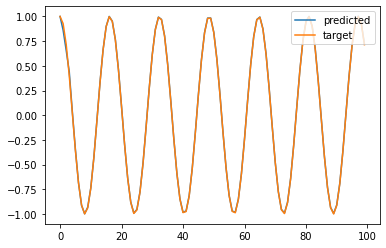

In [ ]:
predicted_signal = torch.hstack([te_data[0,0,0], predictions[0,:,0]])
target_signal = te_data[0,:,0]
plt.plot(predicted_signal.detach(), label='predicted')
plt.plot(target_signal.detach(), label='target')
plt.legend(loc="upper right")
plt.show()

You should obtain an almost perfect matching between the targets and the predicted signals, as shown in the following figure:

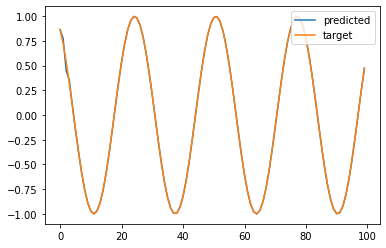

In this case, an RNN solves this simple task almost perfectly. It is indeed relatively easy for the network to observe all the past samples and figure out what could be the next one.

# 5. Language Models (Optional, 5 points)
In this (optional) exercise, we ask you to generate a Shakespeare-like text. Don't worry, you don't have to write it by yourself. Instead, we will train a recurrent neural network to write it for you. To develop such a system, we will follow these steps:
1. We will train a character-based language model using text from Shakespeare's plays. The language model predicts the next character given the previous one (see figure below). This is very similar to what was done before. This time, we predict the next character rather than the next value of the sinusoid.
2. After training the RNN language model, we will generate new texts by properly "sampling" from it.

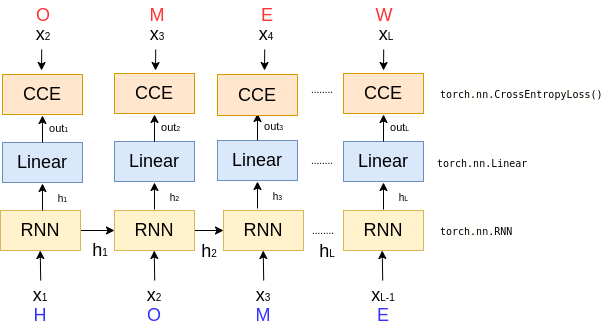

First of all, let's download the text data  from the web.

**Run the following code** to download the data.

In [ ]:
# Download data from google drive repo:
!gdown --id 13WzBACCBG58H4xGzP_mGdpmmtvDUppZZ # Train data
!gdown --id 1G_VaOgs_eYs9vfkFVf0sJ1ELanq5zEuO  # Test data

Downloading...
From: https://drive.google.com/uc?id=13WzBACCBG58H4xGzP_mGdpmmtvDUppZZ
To: /content/trainset.pkl
100% 689k/689k [00:00<00:00, 119MB/s]
Downloading...
From: https://drive.google.com/uc?id=1G_VaOgs_eYs9vfkFVf0sJ1ELanq5zEuO
To: /content/testset.pkl
100% 306k/306k [00:00<00:00, 86.7MB/s]


### Exercise 5.1 - Data Preparation (1 point)
The training and test data are stored in two pickle files:
- trainset.pkl
- testset.pkl

**Write a code to read** the downloaded data. Training data must be stored in a variable called `train_data`, while test data must be stored in a variable called `test_data`.

In [ ]:
import pickle

# Your code here. Aim for 4 lines
file = open("trainset.pkl", "rb")
train_data = pickle.load(file)

file = open("testset.pkl", "rb")
test_data = pickle.load(file)

print(train_data[0])

 him? My cousin Juliet?

LUCIO:
Is she your cousin?

ISABELLA:
Adoptedly; as school-maids change the


As you can see, the data are saved in a list of strings where each element contains a string of 100 characters. For instance, if you print the first sentence of the training data (`print(train_data[0])`) you should see:


```
 him? My cousin Juliet?

LUCIO:
Is she your cousin?

ISABELLA:
Adoptedly; as school-maids change the
```

There are 6270 strings for training and 2790 for testing.

Before moving on, we have to write some support function that allows us to train our model. The first thing to do is to figure out which set of characters is used in the training set.


**Write a code** to define the set of characters. You have to join all the training data into a single big string. Then you have to use the function `set` followed by the `sorted` one to sort the set of characters. Finally, convert everything into a list.


In [ ]:
# Write your code here (aim for 1 line of code)
char_set= list(sorted(set(''.join(train_data))))
print(char_set)

['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


If you print `char_set` you have to see:

`['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F',..... ]`

The lenght of the output list must be 65.

We cannot feed characters into a neural network. We need to convert them into numbers. Now, you have to write a function that takes in input the dataset (either the list of strings in `train_data` or `test_data`) and converts all the characters into their corresponding index in the `char_set`.

For instance, the sequence of char "hello" must be converted into the following tensor of indexes: `tensor([[46, 43, 50, 50, 53]])`.

**Complete the code below** to convert the training and test dataset to their indexes. *Hint*: You can use the method `.index` in  `char_set` to find the index corresponding to a certain character.

In [ ]:
def from_chars_to_indexes(data, char_set):
  """This function converts all the strings available in the data list into 
  a tensor of indexes. The conversion between char and index is done based on
  the content of the char_set.
    
    Arguments
    ---------
    data : List
      A list containing strings to convert.

    char_set :    List
      A list containing the set of characters. The first element corresponds to
      index 0, the second to index 1, and so on. 

    
    Returns
    ---------
    data_index: torch.Tensor
      Tensor (N,L) containing the indexes corresponding to the input chars. N is 
      the number of text chunks and L is the number of char in each chunk.   
  """
  data_index = []
  # Your code here. Aim for 8-10 lines
  for string in data:
    element = []
    for ch in string:
      element.append(char_set.index(ch))
    data_index.append(element)
  return torch.tensor(data_index, dtype=torch.int64)

# Convert the train and test data
train_data = from_chars_to_indexes(train_data, char_set) 
test_data = from_chars_to_indexes(test_data, char_set)

**Check your answer** by running the code below:

In [ ]:
print(from_chars_to_indexes(['hello'], char_set))
assert train_data.dtype==torch.int64, "Expected out to be int64"
assert train_data.shape==(6270,100), "Unexpected shape"
assert test_data.dtype==torch.int64, "Expected out to be int64"
assert test_data.shape==(2790,100), "Unexpected shape"
assert test_data.min()==0, "Unexpected min index"
assert test_data.max()==64, "Unexpected max index"
ind =  from_chars_to_indexes(['hello'], char_set)
ind_expected = torch.Tensor([[46, 43, 50, 50, 53]])
assert torch.equal(ind.float(),ind_expected), "Unexpeced index conversion"
print("Correct!")

tensor([[46, 43, 50, 50, 53]])
Correct!


For this exercise, we convert our datasets into PyTorch data loader objects. This operation is generally convenient because the data loader object implements useful functionalities. For instance, it creates batches for us, shuffles data, etc. 

For more information see [this tutorial](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html).

**Run the code below** to create the data loader for the training data.

In [ ]:
batch_size = 128
# First, we have to convert our list into a dataset object
tr_dataset = torch.utils.data.TensorDataset(train_data)

# Finally, we can create the Dataloader object
tr_loader = torch.utils.data.DataLoader(tr_dataset, batch_size=batch_size, shuffle=True)

### Exercise 5.2 — Create the Model (1 point)
We are now ready to implement the model described above. The model is essentially the same as the one implemented in the previous exercise.

The main differences are the following:
- This time, we use an LSTM (`torch.nn.LSTM`). See the documentation [here](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html).

- We use dropout as well within the LSTM. Just pass the dropout variable (set by default to 0.1) when you initialize the LSTM.

- Before feeding the char indexes into the network, we have to convert the indexes into embedding vectors. This can be done with `torch.nn.Embedding` (see the documentation [here](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html)). We can choose an embedding dimension of 75.

- Since we use the categorical cross-entropy loss, we do not have to convert the linear transformation into a set of probabilities using the softmax (at training/test time). This step is already included in `torch.nn.CrossEntropyLoss` (see the documentation [here](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)). 

- This time, we will feed the initial hidden state h_0 into the RNN (by default it is set to None). Moreover, we return the last hidden state of the RNNs as well (see `torch.nn.LSTM` documentation). This will be useful later when we will use the model to generate text.


**Complete the code below** to create the RNN for language modeling.

In [ ]:
class charRNN(torch.nn.Module):
  def __init__(self, char_set_size=10, embedding_dim=75, hidden_size=8, num_layers=1, dropout=0.1):
    super(charRNN, self).__init__()
    # Youe code here
    self.embedder = torch.nn.Embedding(char_set_size, embedding_dim=embedding_dim)
    self.rnn = torch.nn.LSTM(input_size=embedding_dim, hidden_size=hidden_size, num_layers=num_layers, dropout=dropout, batch_first=True)
    self.linear = torch.nn.Linear(hidden_size, char_set_size)
  
  def forward(self, X, h_0=None):
    """This function processes the input sequence X from the last 
    element to the first one using an RNN.
    On top of each hidden state, a linear transformation
    that returns a scalar prediction for each time step is applied.
    
    Arguments
    ---------
    X : torch.Tensor
      Tensor containing the sequence of char (N, L).
    h_0 : torch.Tensor
      Initial hidden state. By default is None. This means that it will be 
      internally initialized to zero when instantiating the torch.nn.LSTM object.

    Returns
    ---------
    out: torch.Tensor
      Tensor (N,L,1) containing the output at each time step.
    h_n: torch.Tensor
      Last hidden state.     
    """
    # Run the RNN encoder
    # Your code here. Aim for 1 line
    h_n = h_0
    embeddings = self.embedder(X)
    H, h_n = self.rnn(embeddings, h_n)
    out = self.linear(H)

    return out, h_n

### Exercise 5.3 &mdash; Training Loop (1 point)
Now, we can train the model. This step is very similar to what was done in the previous exercise. We have to use the Categorical Cross-Entropy as an objective function. This requires properly transposing the tensor to match the dimensionality expected by this loss function.
As in the previous exercise, you can derive the labels $y$ by shifting the input X to the left (one way is to use `torch.roll`). Remember to remove the last time step to both inputs and labels (due to the aforementioned shift).

**Note**: training this model takes some time (e.g., 7-8 minutes using the GPU). To use the GPU, go to `Runtime`=>`Change runtime type` and choose `GPU` as hardware accelerator". Note that this will **change the computing node** (and it will cancel all the previous output). If that happens, you just have to run the previous steps (the code won't be deleted of course). 

**Complete the code** to implement the training loop:

In [ ]:
CUDA_LAUNCH_BLOCKING=1
# Hyperparameters
num_epoch = 100
lr = 0.001
hidden_size = 256
num_layers= 2
embedding_dim = 75
dropout = 0.5
device = 'cuda:0' # use 'cpu' if a GPU is not available.
char_set_size = len(char_set)
# Initialization
# Your code here
rnn = charRNN(char_set_size=char_set_size, embedding_dim=embedding_dim, hidden_size=hidden_size, num_layers=num_layers, dropout=dropout)
rnn.to(device)
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=lr)

def training_loop(X, model, loss, optimizer, num_epoch=500, batch_size=100, device='cpu'):
  # Training Loop
  for epoch in range(num_epoch):

    for i, X in enumerate(tr_loader):
      
      # Input/Labels Manipulation
      X = X[0]
      # print(X.shape)
      # print(X)
      # Derive the labels (shift x)
      y = torch.roll(X, -1, 1)
      
      # Remove last step for X and y
      X= X[:, :-1]
      y= y[:, :-1]

      # Putting X and y and the specified device
      X = X.to(device)
      y = y.to(device=device)

      # Run the RNN 
      # Your code here. Aim for 1 line
      out, hn = rnn(X)
      
      # Compute the loss
      # Your code here. Aim for 1 line. Suggestion: make sure you transpose correctly.
      # print(out.squeeze(2).shape)
      # print(out.transpose(1, 2).shape)
      # print(y)
      # print(y.shape)
      l = loss(out.transpose(1, 2), y)

      # Update the parameters (zero_grad, backward, optimization step)
      # Your code here. Aim for 3 line
      rnn.zero_grad()
      l.backward(retain_graph=True)
      optimizer.step()


    # Print loss
    if (epoch + 1) % 10 == 0:
        print("Epoch %03d: Train_loss: %.4f " %(epoch+1, l.item()))

# Run the training loop
training_loop(train_data , rnn, loss, optimizer, num_epoch, batch_size, device)

Epoch 010: Train_loss: 1.7468 
Epoch 020: Train_loss: 1.5603 
Epoch 030: Train_loss: 1.4674 
Epoch 040: Train_loss: 1.3865 
Epoch 050: Train_loss: 1.3600 
Epoch 060: Train_loss: 1.3259 
Epoch 070: Train_loss: 1.3148 
Epoch 080: Train_loss: 1.2554 
Epoch 090: Train_loss: 1.2489 
Epoch 100: Train_loss: 1.2276 


Over the 100 epochs, you should obtain the following training losses:


```
Epoch 010: Train_loss: 1.7946 
Epoch 020: Train_loss: 1.5637 
Epoch 030: Train_loss: 1.4523 
Epoch 040: Train_loss: 1.4279 
Epoch 050: Train_loss: 1.3672 
Epoch 060: Train_loss: 1.3551 
Epoch 070: Train_loss: 1.3228 
Epoch 080: Train_loss: 1.2903 
Epoch 090: Train_loss: 1.2544 
Epoch 100: Train_loss: 1.2200 
```



Now, let's take a look at the performance on the test set. 

**Complete the code below** to compute the loss on the test data.

In [ ]:
# Switch RNN to eval modality
# Your code here. Aim for 1 line for code
rnn.eval()

# Put test data on the right device
test_data = test_data.to(device)

# Running the charRNN on test data
# Your code here. Aim for 1 line for code
out, _ = rnn(test_data)

# Derive test labels (left shift)
# Your code here. Aim for 1 line for code
y_test = torch.roll(test_data, -1, 1)
# print(y_test.shape)

# Remove last time step
# Your code here. Aim for 2 lines for code
out = out.transpose(1,2)[:-1, :]
y_test = y_test[:-1,:] 

# Compute the loss
# Your code here. Aim for 1 line for code
loss_test = loss(out, y_test)

# Print the test loss
print("Test_loss: %.4f " %(loss_test.item()))

Test_loss: 1.5211 


You should obtain a test loss very similar to the training loss:

`Test_loss: 1.4350`

The network is trained on a small text corpus. It tends to slightly overfit despite using dropout as a regularization technique. However, this is not a big issue as the overfitting is minimal.


### Exercise 5.5 &mdash; Text Generation (0.5 points)
Do you think it makes sense to use a bidirectional RNN in this case? Write Yes/No and explain clearly your answer.

**Write your aswer here**

Bidirectional RNN can be used in this case. Its input flows in both directions, and it’s capable of utilizing information from both sides. It’s also a powerful tool for modeling the sequential dependencies between words and phrases in both directions of the sequence.

In summary, BiLSTM adds one more LSTM layer, which reverses the direction of information flow. Briefly, it means that the input sequence flows backward in the additional LSTM layer.




### Exercise 5.6 &mdash; Text Generation (1.5 points)
We are now ready to generate text from our pre-trained RNN. *How can we do that?*

One possible approach is the following:
1. We select a random initial input character.
2. We compute the output probability. We have here to apply the softmax on the output provided by the CharRNN.
3. We select an output character by sampling from the output probability. The sampling can be done using `torch.multinomial` (see documentation [here](https://pytorch.org/docs/stable/generated/torch.multinomial.html)).
4. Repeat steps 2 and 3 until L characters are generated.

Essentially, we generate all the characters one by one within a for loop (this is why we designed the RNN such that it takes in input and hidden state and gives in output another hidden state).


**Complete the following code** to generate text.

In [ ]:
def generate(rnn, L=100):
  """This function generates text of length L characters using the RNN model
    in input
    
    Arguments
    ---------
    rnn : charRNN object
      Pretrained RNN model used to generate text.
    L : int
      Length of the text to generate.

    Returns
    ---------
    output_text: string
      String containing the generated text.    
  """

  # Random sample an input char index (use torch.randint)
  # Your code here. Aim for 1 line for code
  current_input = torch.randint(0, len(char_set), (1, 1)).to(device)
  print(current_input)
  # Initialize the output text
  output_text = ''

  # Loop over all the time steps
  for i in range(L):

    if i==0:
      # Manage the first step
      # Feed the RNN with the current input without giving the hidden state.
      # Your code here. Aim for 1 line for code
      out, h = rnn(current_input)
    else:
      # Feed the RNN with the current input giving the hidden state in input as well
      # Your code here. Aim for 1 line for code
      out, h = rnn(current_input, h)
    
    # Compute probabilities from the output (use torch.nn.functional.softmax)
    # Your code here. Aim for 1 line for code
    out = out[0][-1]
    probs = torch.nn.functional.softmax(out, dim=0).detach()

    # Sample the current output from the proabilities (use torch.multinomial)
    # Your code here. Aim for 1 line for code
    current_output = torch.multinomial(probs, 1)
    
    # Add current output to output text
    # Your code here. Aim for 1 line for code
    output_text += char_set[current_output]

    # Update hidden state (for next h_in)
    # Your code here. Aim for 1 line for code
    h_in = h

    # Update input (for next current inpput)
    # Your code here. Aim for 1 line for code
    current_input = current_output.unsqueeze(1)

  return output_text

rnn.eval()
text = generate(rnn, L=600)
print(text)

tensor([[57]], device='cuda:0')
poely king!
Speak steeds. Streak, my lord, nor together:
But I may talk I would reverend some:
I'll to thy friend, by their servants whose?

JULIET:
Well, sir?

ANGELO:
I partly like a matter, for it being burther's
dreadful.

Poss Murderer:
But when a friend dear to jols think
I were were the feast: when I be leading, so
Camillo this own revengeing our madars
Whereon it shame midnot saw Tybalt, but a ghostly hand
As all fiving aftersuel nothing in Viennes
Are reason,--as both thy mischance of him,
Rescent the Duke of God's cloak. 
KING EDWARD IV:
Well, my mistress! therefore moder meeting lie


If the generation step is implemented correctly, you should obtain text like this:


```
;
And I not like my man, you weep as his will be my love.
The watch in the Pawak of their greats. But if
it is the Cousiny.

PROSPERO:
O Lord Edward, we have barner'd you.

STANLEY:
My lord
Shall be he very deed by your precains out
That much not want: your heeds, would not hear you.
Farewell, faith, and let thee to be that flow.
But their crowment hand with a-standing friends?

KING RICHARD III:
We are this mad: we'll cried my true stain,
Sen thee you from the lives there.

OXFORD:
Then, for thy sheel-stable--

First Lord:
Not sir, for I did continue this curbers:
O that make him speak, or I 
```

You should see that most of the time, the RNN produces valid words. We can see that the network has learned to separate the parts assigned to different actors. The sequence of generated words might make some sense locally, but not globally. For better results, larger models on larger datasets must be used (which is out of the scope of this assignment).

**That's all!**



